In [2]:
import pandas as pd

# Replace 'your_file.xlsx' with the path to your actual Excel file
file_path = 'ulfstatements.xlsx'

# Read the Excel file:
# skiprows=1 skips the first row, so the second row becomes the header
df = pd.read_excel(file_path, skiprows=1)


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Unnamed: 0        16 non-null     object
 1   Unnamed: 1        16 non-null     object
 2   Kennen            16 non-null     object
 3   Verstehen         16 non-null     object
 4   Anwenden          16 non-null     object
 5   Beherrschen       16 non-null     object
 6   db_competency_id  16 non-null     int64 
dtypes: int64(1), object(6)
memory usage: 1.0+ KB


In [ ]:
# --- 3. Reshape (melt) the Excel DataFrame ---
# The level columns in Excel are: 'Kennen', 'Verstehen', 'Anwenden', 'Beherrschen'
df_excel_melted = df.melt(
    id_vars=['db_competency_id'],  # Key column for competency
    value_vars=['Kennen', 'Verstehen', 'Anwenden', 'Beherrschen'],
    var_name='level',
    value_name='definition'
)

In [6]:
df_excel_melted

,db_competency_id,level,definition
0,1,Kennen,Der Teilnehmer kennt die Zusammenhänge seines ...
1,6,Kennen,Die Teilnehmer kennen die Grundlage der Modell...
2,4,Kennen,Die Teilnehmer kennt die Lebenszyklusphasen se...
3,5,Kennen,Die Teilnehmerin ikennt die Grundprinzipien de...
4,14,Kennen,"Prozess: Die Teilnehmer können Bedarfe, Stake..."
...,...,...,...
59,8,Beherrschen,"Teilnehmer ist in der Lage, Teammitglieder str..."
60,10,Beherrschen,Prozess: Der Teilnehmer ist in der Lage Unzulä...
61,11,Beherrschen,Die Teilnehmer können Entscheidungen bewerten ...
62,12,Beherrschen,Der Teilnehmer kann einen umfangreichen Inform...


In [7]:
# Convert the level column in the Excel DataFrame to lowercase for consistency
df_excel_melted['level'] = df_excel_melted['level'].str.lower()


In [8]:
# Convert the level column in the Excel DataFrame to lowercase for consistency
df_excel_melted['level'] = df_excel_melted['level'].str.lower()


In [19]:
from sqlalchemy import create_engine

In [ ]:
# --- 1. Connect to PostgreSQL and query the database ---
import os
conn_string = os.environ.get("DATABASE_URL")
engine = create_engine(conn_string)

query = """
SELECT 
    ci.competency_id,
    ci."level",
    string_agg(ci.indicator_en, ' | ') AS indicator_en,
    c.competency_name
FROM competency_indicators ci
LEFT JOIN competency c ON ci.competency_id = c.id
GROUP BY ci.competency_id, ci."level", c.competency_name
ORDER BY ci.competency_id;
"""

df_db = pd.read_sql(query, engine)
df_db['level'] = df_db['level'].str.lower()  # Normalize to lowercase

In [21]:
# --- 4. Merge the DataFrames ---
# Left join: database DataFrame is the left side, Excel DataFrame is the right side.
merged_df = pd.merge(
    df_db,
    df_excel_melted,
    left_on=['competency_id', 'level'],
    right_on=['db_competency_id', 'level'],
    how='left'
)


In [22]:
merged_df

,competency_id,level,indicator_en,competency_name,db_competency_id,definition
0,1,anwenden,You are able to analyze your present system an...,Systems Thinking,1,"Der Teilnehmer ist in der Lage, sein vorliegen..."
1,1,beherrschen,You are able to carry systemic thinking into t...,Systems Thinking,1,Der Teilnehmer ist in der Lage Systemisches De...
2,1,kennen,You are able to recognize the interrelationshi...,Systems Thinking,1,Der Teilnehmer kennt die Zusammenhänge seines ...
3,1,verstehen,You understand the interaction of the individu...,Systems Thinking,1,Der Teilnehmer versteht die Wechselwirkung der...
4,4,anwenden,"You are able to identify, consider, and assess...",Lifecycle Consideration,4,Der Teilmnehmer ist in der Lage für die für ih...
...,...,...,...,...,...,...
59,17,verstehen,"You understand how the operation, service, and...",Operation and Support,17,"Die Teilnehmer verstehen, wie die Phasen Betri..."
60,18,anwenden,You can effectively work in an Agile environme...,Agile Methods,18,Methode: der Teilnehmer kann in einem agilen U...
61,18,beherrschen,You can define and implement the relevant Agil...,Agile Methods,18,Der Teilnehmer kann für ein projekt die releva...
62,18,kennen,You are aware of the basic principles of Agile...,Agile Methods,18,Methode: Der Teilnehmer kennt die Agilen Werte...


In [13]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   competency_id     84 non-null     int64 
 1   level             84 non-null     object
 2   indicator_en      84 non-null     object
 3   competency_name   84 non-null     object
 4   db_competency_id  84 non-null     int64 
 5   definition        84 non-null     object
dtypes: int64(2), object(4)
memory usage: 4.1+ KB


In [ ]:
import os
import json
from pydantic import BaseModel, Field
from langchain_openai import AzureChatOpenAI
from langchain.schema import HumanMessage
from typing import List
import time
import pandas as pd

# Define a model for the assessment result that includes the level.
class CompetencyAssessment(BaseModel):
    competency_id: int = Field(
        description="The unique identifier of the competency."
    )
    competency_name: str = Field(
        description="The name of the competency."
    )
    level: str = Field(
        description="The competency level (e.g., kennen, verstehen, etc.)."
    )
    indicator_rating: int = Field(
        description="Rating (1-5) for how well the translated indicator captures the level definition."
    )
    translation_rating: int = Field(
        description="Rating (1-5) for the quality of the translation from the German definition to the English indicator."
    )

# Initialize the LangChain LLM using Azure OpenAI parameters.
llm = AzureChatOpenAI(
    model="gpt-4o-mini",
    openai_api_key=os.environ.get("AZURE_API_KEY"),
    azure_endpoint=os.environ.get("AZURE_ENDPOINT"),
    api_version="2024-02-15-preview",
    temperature=0.5
)
# Create a version of the LLM that returns structured output with our updated model.
structured_llm = llm.with_structured_output(CompetencyAssessment)

In [24]:
def assess_competency(competency_id: int, competency_name: str, level: str, indicator_en: str, definition: str) -> CompetencyAssessment:
    """
    Calls the LLM to assess:
    - How well the English indicator captures the original German definition.
    - The quality of the translation.
    Returns a CompetencyAssessment object that includes the competency level.
    """
    prompt_text = f"""
    We have a competency with the following details:

    Competency ID: {competency_id}
    Competency Name: {competency_name}
    Competency Level: {level}

    The original level definition (in German) is:
    "{definition}"

    The translated indicator (in English) is:
    "{indicator_en}"

    Please evaluate the following:
    1. How well does the translated indicator capture the original level definition? Rate it on a scale of 1 to 5.
    2. How good is the translation quality from the German definition to the English indicator? Rate it on a scale of 1 to 5.

    Return your answer as a JSON structure with the following keys:
    - competency_id
    - competency_name
    - level
    - indicator_rating (an integer from 1 to 5)
    - translation_rating (an integer from 1 to 5)

    Ensure your output is valid JSON.
    """
    try:
        print(f"Calling LLM for competency_id {competency_id} at level {level}")
        assessment_result = structured_llm.invoke(prompt_text)
        return assessment_result
    except Exception as e:
        print(f"Error processing competency_id {competency_id} (level: {level}): {e}")
        raise



In [25]:
# Assume merged_df is already defined with columns:
# ['competency_id', 'level', 'indicator_en', 'competency_name', 'db_competency_id', 'definition']

# List to store assessment results
assessment_results = []

# Iterate over each row in merged_df and call the LLM
for index, row in merged_df.iterrows():
    try:
        result = assess_competency(
            competency_id=row['competency_id'],
            competency_name=row['competency_name'],
            level=row['level'],
            indicator_en=row['indicator_en'],
            definition=row['definition']
        )
        assessment_results.append(result.model_dump())
    except Exception as e:
        print(f"Skipping row index {index} due to error: {e}")
        continue
    # Optional: Pause between calls to avoid rate limits.
    time.sleep(3)

# Convert the assessment results into a DataFrame
df_assessments = pd.DataFrame(assessment_results)

# Merge the assessments with the original merged_df if needed:
final_df = pd.merge(merged_df, df_assessments, on=['competency_id', 'competency_name', 'level'], how='left')



Calling LLM for competency_id 1 at level anwenden
Calling LLM for competency_id 1 at level beherrschen
Calling LLM for competency_id 1 at level kennen
Calling LLM for competency_id 1 at level verstehen
Calling LLM for competency_id 4 at level anwenden
Calling LLM for competency_id 4 at level beherrschen
Calling LLM for competency_id 4 at level kennen
Calling LLM for competency_id 4 at level verstehen
Calling LLM for competency_id 5 at level anwenden
Calling LLM for competency_id 5 at level beherrschen
Calling LLM for competency_id 5 at level kennen
Calling LLM for competency_id 5 at level verstehen
Calling LLM for competency_id 6 at level anwenden
Calling LLM for competency_id 6 at level beherrschen
Error processing competency_id 6 (level: beherrschen): Error code: 400 - {'error': {'message': "The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please rea

In [26]:
final_df.to_csv("final_assessments_updated__1.csv", index=False)

## Processing flagged calls

In [29]:
from langchain_openai import AzureOpenAIEmbeddings
import numpy as np

In [ ]:
# Configuration variables (ensure these are set in your environment or code)

api_key = os.environ.get("AZURE_API_KEY")
api_base = os.environ.get("AZURE_API_BASE")
api_version = "2024-02-01"
azure_embedding_deployment_name = "text-embedding-ada-002"

In [30]:
# Initialize the Azure OpenAI Embeddings instance.
azure_embeddings = AzureOpenAIEmbeddings(
    api_key=api_key,
    azure_endpoint=api_base,
    openai_api_version=api_version,
    model=azure_embedding_deployment_name
)

# Function to compute cosine similarity
def cosine_similarity(vec1, vec2):
    return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))

In [32]:
# Function to compute cosine similarity
def cosine_similarity(vec1, vec2):
    return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))

# Load the CSV file into a DataFrame
df = pd.read_csv("final_assessments_updated__1.csv")

# Compute similarity for each row and add as a new column.
def compute_similarity(row):
    # Compute embeddings for indicator_en and definition.
    # These functions return lists/floats; ensure they are numpy arrays.
    vec_indicator = np.array(azure_embeddings.embed_query(row['indicator_en']))
    vec_definition = np.array(azure_embeddings.embed_query(row['definition']))
    return cosine_similarity(vec_indicator, vec_definition)

df['embedding_similarity'] = df.apply(compute_similarity, axis=1)

# Save updated DataFrame to CSV
df.to_csv("final_assessments_with_similarity.csv", index=False)
print("Updated DataFrame saved to 'final_assessments_with_similarity.csv'")

Updated DataFrame saved to 'final_assessments_with_similarity.csv'


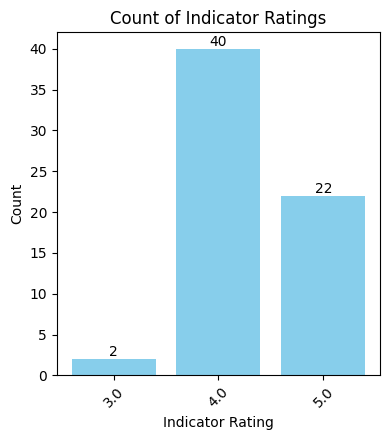

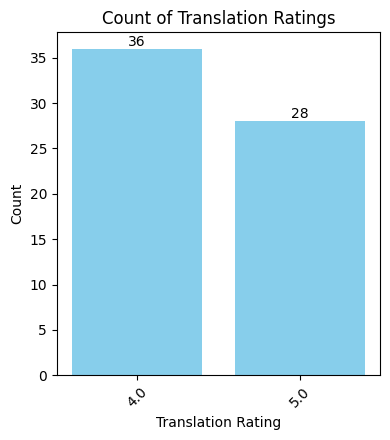

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
# Load the Excel file
file_path = "final_assessments_with_similarity.csv"  # Change this to your actual file path
df = pd.read_csv(file_path)

# Group by indicator_rating and count occurrences
indicator_counts = df.groupby("indicator_rating").size()

# Group by translation_rating and count occurrences
translation_counts = df.groupby("translation_rating").size()

def plot_bar_chart(data, xlabel, ylabel, title):
    plt.figure(figsize=(4, 4.5))  # Adjusted smaller figure size
    bars = plt.bar(data.index.astype(str), data.values, color="skyblue")

    # Add labels on bars
    for bar in bars:
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), 
                 str(bar.get_height()), ha='center', va='bottom', fontsize=10)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Plot for indicator_rating
plot_bar_chart(indicator_counts, "Indicator Rating", "Count", "Count of Indicator Ratings")

# Plot for translation_rating
plot_bar_chart(translation_counts, "Translation Rating", "Count", "Count of Translation Ratings")

# Corelation Analysis

Correlation between embedding similarity and indicator rating: 0.576
Correlation between embedding similarity and translation rating: 0.437


/var/folders/sf/hrd25tt16ll03z02j7dfk2km0000gn/T/ipykernel_66822/399716976.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df["indicator_rating"].astype(str), y=df["embedding_similarity"], palette="Blues")


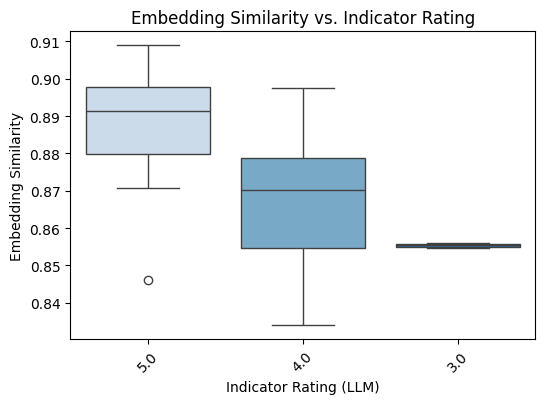

/var/folders/sf/hrd25tt16ll03z02j7dfk2km0000gn/T/ipykernel_66822/399716976.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df["translation_rating"].astype(str), y=df["embedding_similarity"], palette="Greens")


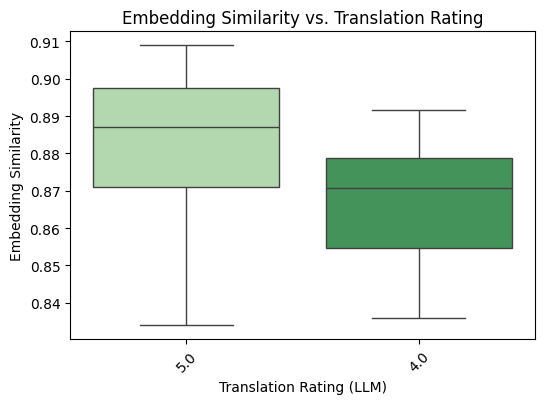

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the Excel file
file_path = "final_assessments_with_similarity.csv"  # Change this to your actual file path
df = pd.read_csv(file_path)

# Correlation Analysis
correlation_indicator = df[['embedding_similarity', 'indicator_rating']].corr().iloc[0, 1]
correlation_translation = df[['embedding_similarity', 'translation_rating']].corr().iloc[0, 1]

print(f"Correlation between embedding similarity and indicator rating: {correlation_indicator:.3f}")
print(f"Correlation between embedding similarity and translation rating: {correlation_translation:.3f}")

# Distribution Analysis: Group similarity by rating
plt.figure(figsize=(6, 4))
sns.boxplot(x=df["indicator_rating"].astype(str), y=df["embedding_similarity"], palette="Blues")
plt.xlabel("Indicator Rating (LLM)")
plt.ylabel("Embedding Similarity")
plt.title("Embedding Similarity vs. Indicator Rating")
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(6, 4))
sns.boxplot(x=df["translation_rating"].astype(str), y=df["embedding_similarity"], palette="Greens")
plt.xlabel("Translation Rating (LLM)")
plt.ylabel("Embedding Similarity")
plt.title("Embedding Similarity vs. Translation Rating")
plt.xticks(rotation=45)
plt.show()


## Anova

In [6]:
import pandas as pd
import scipy.stats as stats

# Load the Excel file
file_path = "final_assessments_with_similarity.csv"  # Change this to your actual file path
df = pd.read_csv(file_path)
# Perform one-way ANOVA for indicator_rating
anova_indicator = stats.f_oneway(
    *[df[df["indicator_rating"] == rating]["embedding_similarity"] for rating in df["indicator_rating"].unique()]
)

# Perform one-way ANOVA for translation_rating
anova_translation = stats.f_oneway(
    *[df[df["translation_rating"] == rating]["embedding_similarity"] for rating in df["translation_rating"].unique()]
)

print(f"ANOVA p-value for Indicator Rating: {anova_indicator.pvalue:.5f}")
print(f"ANOVA p-value for Translation Rating: {anova_translation.pvalue:.5f}")

# Interpretation
if anova_indicator.pvalue < 0.05:
    print("Significant difference found for Indicator Rating → LLM ratings depend on embedding similarity.")
else:
    print("No significant difference found for Indicator Rating → LLM ratings may not depend on embedding similarity.")

if anova_translation.pvalue < 0.05:
    print("Significant difference found for Translation Rating → LLM ratings depend on embedding similarity.")
else:
    print("No significant difference found for Translation Rating → LLM ratings may not depend on embedding similarity.")


ANOVA p-value for Indicator Rating: 0.00000
ANOVA p-value for Translation Rating: 0.00031
Significant difference found for Indicator Rating → LLM ratings depend on embedding similarity.
Significant difference found for Translation Rating → LLM ratings depend on embedding similarity.


In [7]:
anova_indicator.pvalue

3.624186515008559e-06

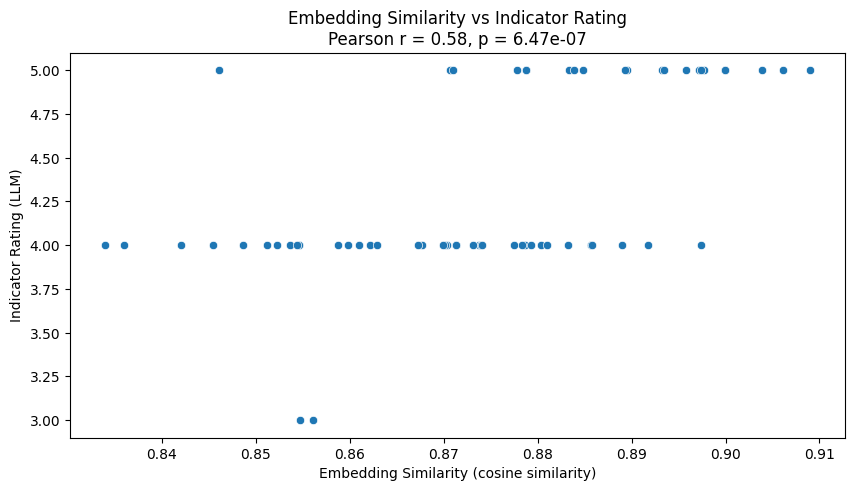

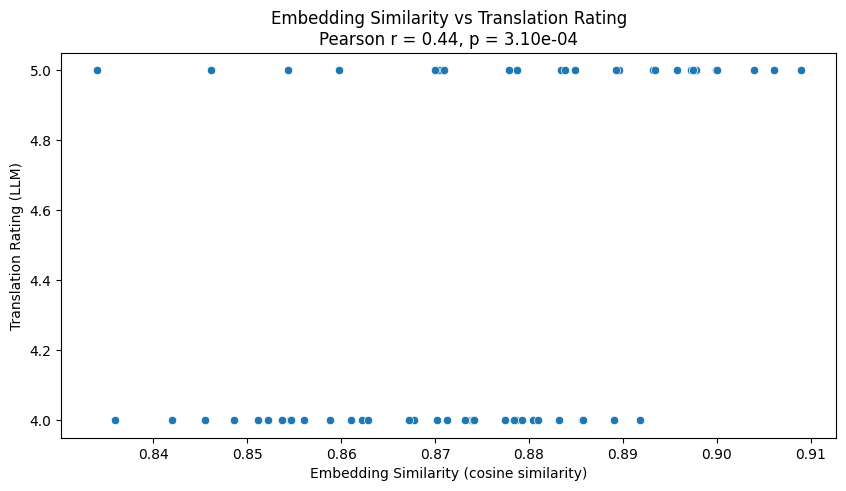

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

# Load the updated DataFrame with similarity scores and LLM ratings.
df = pd.read_csv("final_assessments_with_similarity.csv")

# Compute Pearson correlations for indicator_rating and translation_rating
corr_indicator, p_val_indicator = pearsonr(df['embedding_similarity'], df['indicator_rating'])
corr_translation, p_val_translation = pearsonr(df['embedding_similarity'], df['translation_rating'])

# Create a scatter plot for embedding_similarity vs indicator_rating
plt.figure(figsize=(10, 5))
sns.scatterplot(x='embedding_similarity', y='indicator_rating', data=df)
plt.title(f'Embedding Similarity vs Indicator Rating\nPearson r = {corr_indicator:.2f}, p = {p_val_indicator:.2e}')
plt.xlabel('Embedding Similarity (cosine similarity)')
plt.ylabel('Indicator Rating (LLM)')
plt.show()

# Create a scatter plot for embedding_similarity vs translation_rating
plt.figure(figsize=(10, 5))
sns.scatterplot(x='embedding_similarity', y='translation_rating', data=df)
plt.title(f'Embedding Similarity vs Translation Rating\nPearson r = {corr_translation:.2f}, p = {p_val_translation:.2e}')
plt.xlabel('Embedding Similarity (cosine similarity)')
plt.ylabel('Translation Rating (LLM)')
plt.show()


/var/folders/sf/hrd25tt16ll03z02j7dfk2km0000gn/T/ipykernel_2847/1438923635.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby('similarity_bin')['indicator_rating'].mean().reset_index()


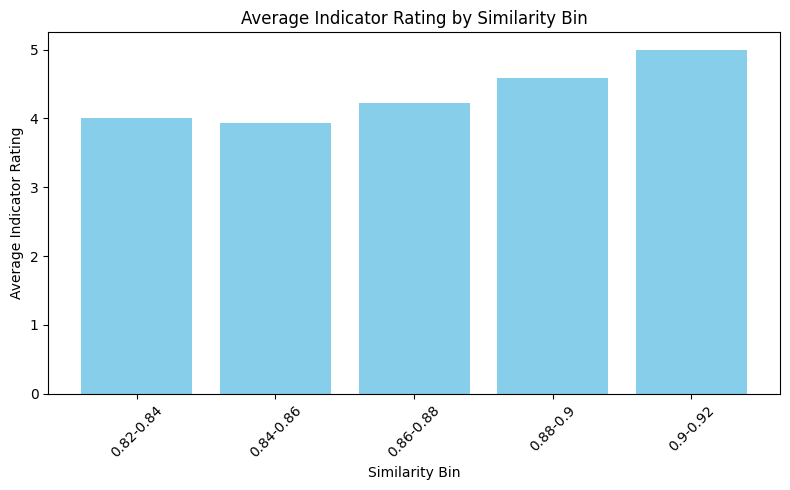

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("final_assessments_with_similarity.csv")

# Create bins for similarity scores (adjust bin edges as needed).
bins = [0.80, 0.82, 0.84, 0.86, 0.88, 0.90, 0.92]
labels = [f"{bins[i]}-{bins[i+1]}" for i in range(len(bins)-1)]
df['similarity_bin'] = pd.cut(df['embedding_similarity'], bins=bins, labels=labels, include_lowest=True)

# Group by bins and compute average rating
grouped = df.groupby('similarity_bin')['indicator_rating'].mean().reset_index()

# Plot
plt.figure(figsize=(8, 5))
plt.bar(grouped['similarity_bin'], grouped['indicator_rating'], color='skyblue')
plt.xlabel("Similarity Bin")
plt.ylabel("Average Indicator Rating")
plt.title("Average Indicator Rating by Similarity Bin")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


/var/folders/sf/hrd25tt16ll03z02j7dfk2km0000gn/T/ipykernel_2847/3884054370.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby('similarity_bin').agg({


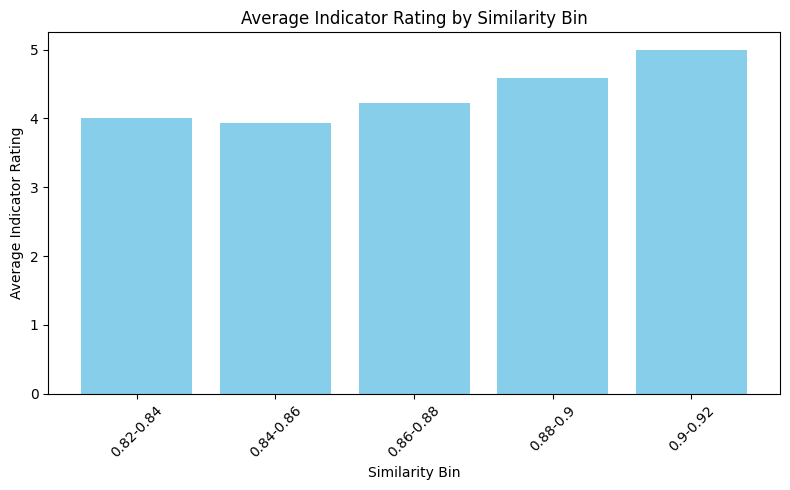

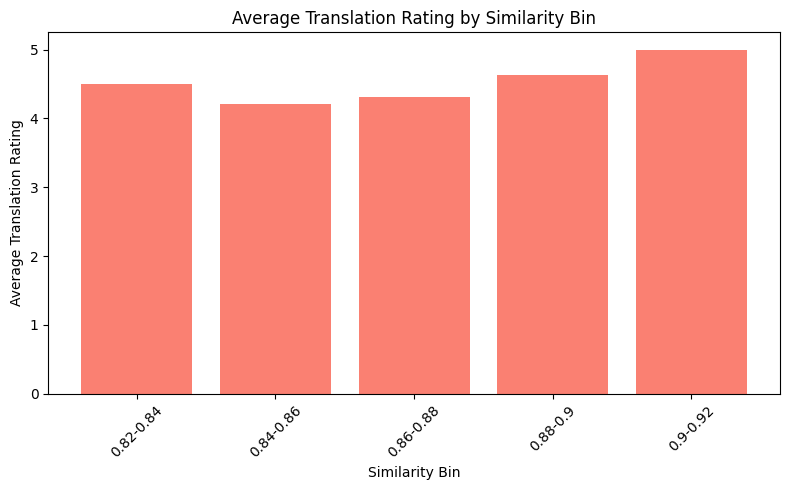

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("final_assessments_with_similarity.csv")

# Define bins for similarity scores
bins = [0.80, 0.82, 0.84, 0.86, 0.88, 0.90, 0.92]
labels = [f"{bins[i]}-{bins[i+1]}" for i in range(len(bins)-1)]

# Bin the similarity scores
df['similarity_bin'] = pd.cut(df['embedding_similarity'], bins=bins, labels=labels, include_lowest=True)

# Group by bins and compute average indicator_rating and translation_rating
grouped = df.groupby('similarity_bin').agg({
    'indicator_rating': 'mean',
    'translation_rating': 'mean'
}).reset_index()

# --- Plot for Indicator Rating ---
plt.figure(figsize=(8, 5))
plt.bar(grouped['similarity_bin'], grouped['indicator_rating'], color='skyblue')
plt.xlabel("Similarity Bin")
plt.ylabel("Average Indicator Rating")
plt.title("Average Indicator Rating by Similarity Bin")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# --- Plot for Translation Rating ---
plt.figure(figsize=(8, 5))
plt.bar(grouped['similarity_bin'], grouped['translation_rating'], color='salmon')
plt.xlabel("Similarity Bin")
plt.ylabel("Average Translation Rating")
plt.title("Average Translation Rating by Similarity Bin")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


/var/folders/sf/hrd25tt16ll03z02j7dfk2km0000gn/T/ipykernel_2847/4077361269.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby('similarity_bin').agg({


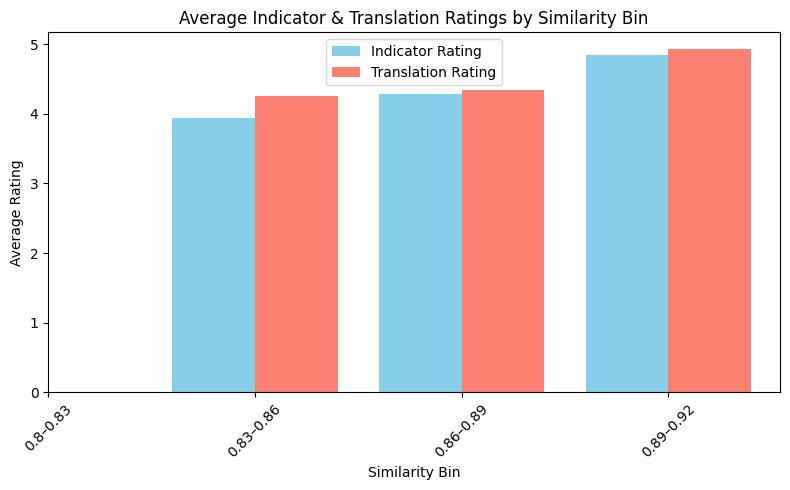

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Example DataFrame: final_assessments_with_similarity.csv
df = pd.read_csv("final_assessments_with_similarity.csv")

# Define custom bins for similarity scores (adjust as desired).
# Here, we have 4 bins spanning from 0.80 to 0.92.
bins = [0.80, 0.83, 0.86, 0.89, 0.92]
labels = [f"{bins[i]}–{bins[i+1]}" for i in range(len(bins) - 1)]

# Bin the similarity scores into these custom ranges.
df['similarity_bin'] = pd.cut(df['embedding_similarity'], bins=bins, labels=labels, include_lowest=True)

# Group by bins and compute average indicator_rating and translation_rating
grouped = df.groupby('similarity_bin').agg({
    'indicator_rating': 'mean',
    'translation_rating': 'mean'
}).reset_index()

# Create a side-by-side bar chart.
x = np.arange(len(grouped))  # the label locations
bar_width = 0.4

fig, ax = plt.subplots(figsize=(8, 5))

# Bar for indicator_rating
rects1 = ax.bar(
    x - bar_width/2, 
    grouped['indicator_rating'], 
    width=bar_width, 
    label='Indicator Rating',
    color='skyblue'
)

# Bar for translation_rating
rects2 = ax.bar(
    x + bar_width/2, 
    grouped['translation_rating'], 
    width=bar_width, 
    label='Translation Rating',
    color='salmon'
)

# Add labels, title, legend, and custom x-axis tick labels
ax.set_xlabel("Similarity Bin")
ax.set_ylabel("Average Rating")
ax.set_title("Average Indicator & Translation Ratings by Similarity Bin")
ax.set_xticks(x)
ax.set_xticklabels(grouped['similarity_bin'], rotation=45)
ax.legend()

plt.tight_layout()
plt.show()


/var/folders/sf/hrd25tt16ll03z02j7dfk2km0000gn/T/ipykernel_2847/776006194.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby('similarity_bin').agg({
/var/folders/sf/hrd25tt16ll03z02j7dfk2km0000gn/T/ipykernel_2847/776006194.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_counts = df.groupby('similarity_bin').size().reset_index(name='count')


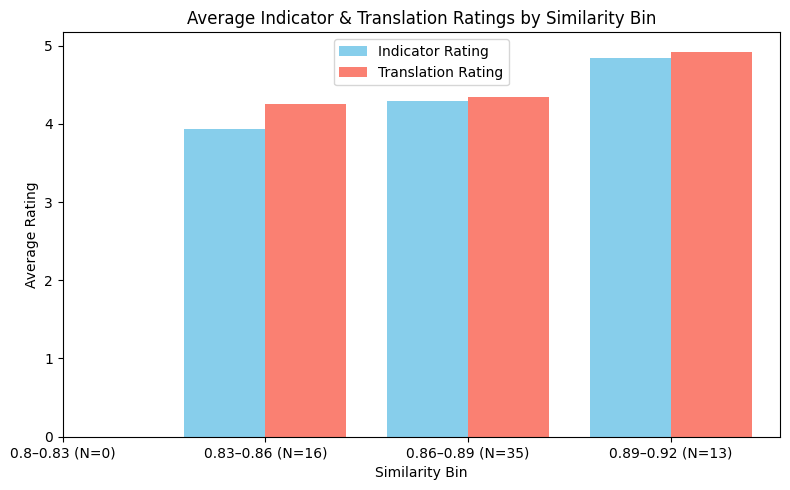

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Example DataFrame: final_assessments_with_similarity.csv
df = pd.read_csv("final_assessments_with_similarity.csv")

# Define custom bins for similarity scores
bins = [0.80, 0.83, 0.86, 0.89, 0.92]
labels = [f"{bins[i]}–{bins[i+1]}" for i in range(len(bins) - 1)]

# Bin the similarity scores
df['similarity_bin'] = pd.cut(df['embedding_similarity'], bins=bins, labels=labels, include_lowest=True)

# Group by bins and compute average indicator_rating and translation_rating
grouped = df.groupby('similarity_bin').agg({
    'indicator_rating': 'mean',
    'translation_rating': 'mean'
}).reset_index()

# Also get the count of rows in each bin to display (N=...)
grouped_counts = df.groupby('similarity_bin').size().reset_index(name='count')

# Create a side-by-side bar chart
x = np.arange(len(grouped))  # the label locations
bar_width = 0.4

fig, ax = plt.subplots(figsize=(8, 5))

# Bar for indicator_rating
rects1 = ax.bar(
    x - bar_width / 2,
    grouped['indicator_rating'],
    width=bar_width,
    label='Indicator Rating',
    color='skyblue'
)

# Bar for translation_rating
rects2 = ax.bar(
    x + bar_width / 2,
    grouped['translation_rating'],
    width=bar_width,
    label='Translation Rating',
    color='salmon'
)

# Build custom x-axis labels that include N for each bin
x_labels = []
for i in range(len(grouped)):
    bin_label = grouped.loc[i, 'similarity_bin']
    # Find the count for this bin
    n_count = grouped_counts.loc[grouped_counts['similarity_bin'] == bin_label, 'count'].values[0]
    # Format the label to show the bin range and (N=...)
    x_labels.append(f"{bin_label} (N={n_count})")

ax.set_xlabel("Similarity Bin")
ax.set_ylabel("Average Rating")
ax.set_title("Average Indicator & Translation Ratings by Similarity Bin")

# Replace the default tick labels with our custom labels
ax.set_xticks(x)
ax.set_xticklabels(x_labels)

ax.legend()

plt.tight_layout()
plt.show()

